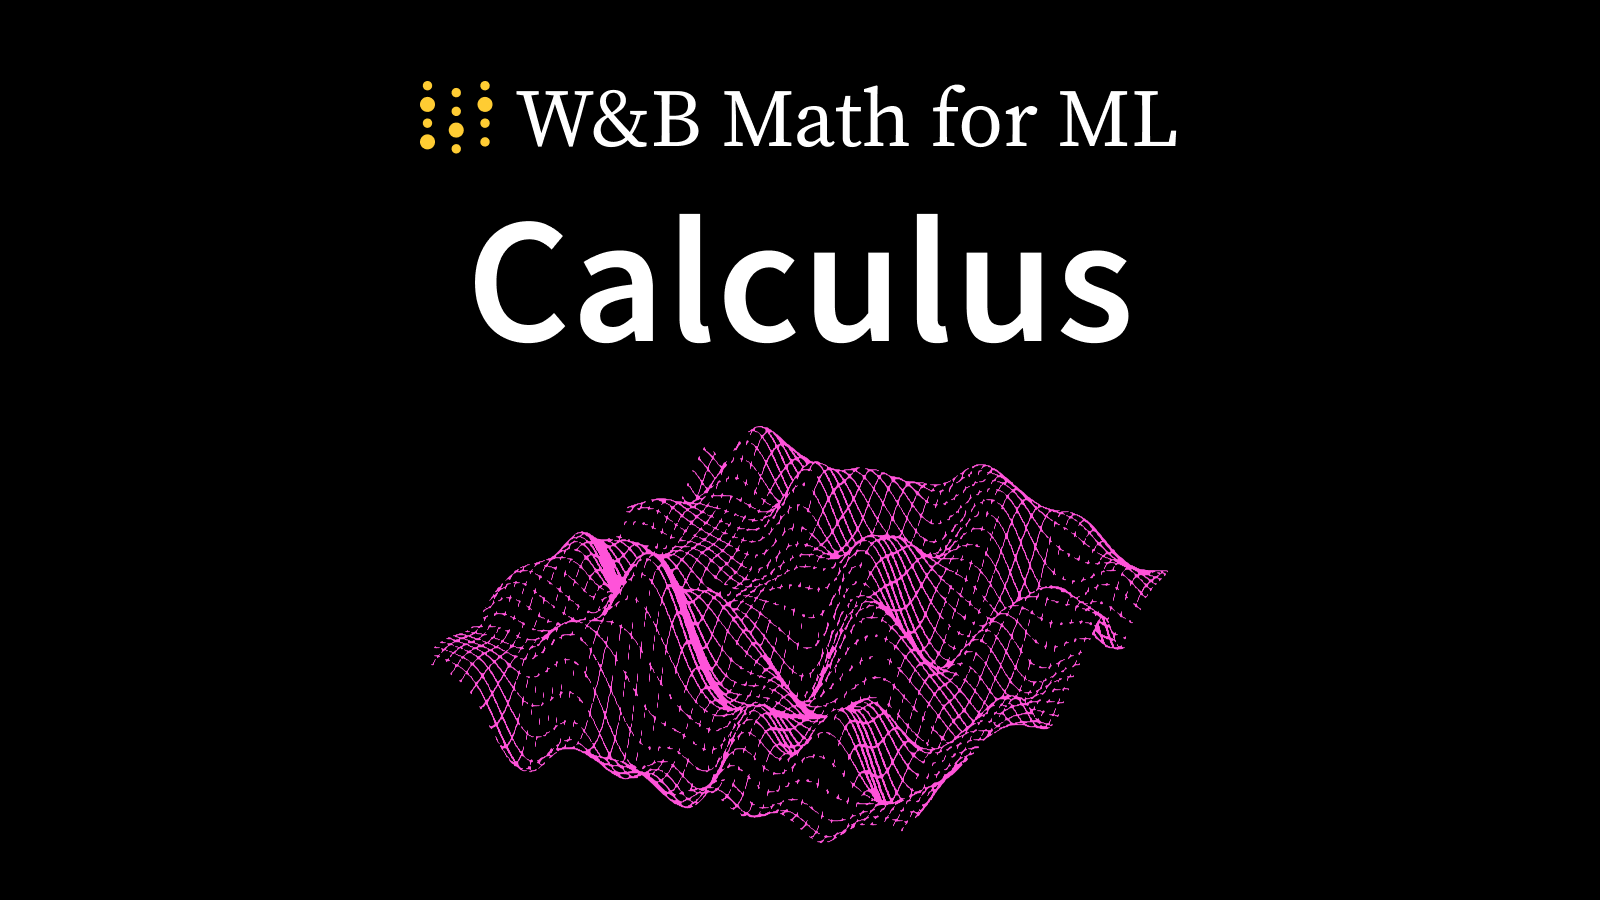

## Setup Code

This section includes setup code for the remaining sections.

In [ ]:
%%capture

if "google.colab" in str(get_ipython()):
    %cd "/content/"
    !git clone "https://github.com/wandb/edu.git"
    %cd "edu/math-for-ml"
    !pip install --upgrade -r requirements-colab.txt
    %cd "02_calculus"
else:
    pass

# importing from standard library
from collections.abc import Callable
import random
import sys
import warnings

# importing libraries
import autograd
import autograd.numpy as np  # trick for automatic differentiation with numpy
import matplotlib.pyplot as plt
import sympy
from sympy.abc import x
import wandb

if "../" not in sys.path:
    sys.path.append("../")

# importing course-specific modules
import autograder
import utils

# ignoring autograd warning about derivatives of constant functions
warnings.simplefilter("ignore", category=UserWarning, lineno=14)

In [ ]:
wandb.login()

In [ ]:
try:
    grader
except NameError:
    grader = autograder.WandbTrackedOK(
        "wandb", "utils/config", "calculus", "utils/")

# Little-$o$ Notation

In
[the lecture associated with this notebook](http://wandb.me/m4ml-video-2),
we discussed the benefits of the "little-$o$" notation
for writing the gradient as a linear approximation --
the [Frechet derivative](https://charlesfrye.github.io/math/2018/03/06/frechet-derivative-introduction.html)
style:



$$
f(x + \varepsilon) = f(x) + \nabla f(x)^\top \varepsilon + o(\varepsilon)
$$

where $f$ is the function being approximated, $\nabla f$ is its gradient, and
$a^\top b$ is the inner/dot/scalar product of $a$ and $b$.

Intuitively, we think of $o(\varepsilon)$ as the "approximation error"
if we approximate $f$ at $x + \varepsilon$
using the gradient as a linear approximatiun.

Formally, the meaning of $o$ is that:

$$
f(x) = o(g(x)) \text{ implies } \lim_{x\rightarrow 0} \frac{f(x)}{g(x)} = 0
$$

Let's build our intuition for $o$ with some examples.

We'll use [`sympy`](https://www.sympy.org/en/index.html),
a Python library for doing symbolic math
(limits, integrals, algebra, and more!),
to programmatically check whether different functions $f$ are
or are not little-$o$ of other functions $g$,
using the helper method below:

In [ ]:
def is_little_o(g_x, f_x, x):
    """Returns whether the expression f_x is little-o of g_x.
  
    That is, it evaluates:
    $$
      f(x) ?= o(g(x))
    $$
    using sympy.
    
    Arguments:
      g_x: sympy.Expression. The "inner" function, o(g(x)). Usually a simple
          function of x, like x, x ** 2, etc.
      f_x: sympy.Expression. The "outer" function, f(x), whose behavior near 0 is
          being compared to the behavior of g_x.
      x: sympy.Symbol. The variable in the expressions g_x and f_x.
    """
    limit = sympy.limit(f_x / g_x,  # expression to take the limit of
                        x,  # variable/Symbol to take the limit with respect to
                        0  # take the limit as x goes to this value
                        )
    return limit == 0

`sympy.limit` automatically computes limits, which lets us check whether
the limit-based definition of $o(g(x))$ is satisfied by a function $f(x)$
without having to compute any limits ourselves!

`is_little_o` operates on `sympy.Expression`s and `sympy.Symbol`s.

A `sympy.Symbol` is like a variable -- we only need one here, `x`,
which was imported above.


In [ ]:
print(isinstance(x, sympy.Symbol))
x

We represent our functions $f$ and $g$
with `sympy.Expression`s containing the variable `x`.

We can build an `Expression` by applying
mathematical operations to our variables,
just like we might build an expression in Python:

In [ ]:
expressions = [x, 5 * x, x ** 2, sympy.sin(x)]

expressions[2]  # change the index to see the other expressions

> _Note:_ We can build expressions with
numbers (`float` or `int`)
and operators (`+`, `*`. `-`, `/`. `**`)
and `sympy` functions (`sympy.exp`, `sympy.log`, `sympy.cos`),
but _not_ `numpy` functions or other Python operations.

Putting it together,
our `is_little_o` function is called by passing in
an expression for $g(x)$ as the first argument (`g_x`),
an expression for $f(x)$ as the second argument (`f_x`),
and the symbol for $x$ as the final argument (`x`).

Check out the two examples below:

In [ ]:
(is_little_o(x, x, x),  # is lim x/x as x -> 0 equal to 0?
  is_little_o(x, x ** 2, x))  # is lim x**2/x as x -> 0 equal to 0?

Before moving on to the exercises,
take this function for a spin in the cell below.
Try providing different inputs for `f_x` and `g_x`
(`x ** 2`, `x ** 1000`, `1 / x`, `10 * x`)
and guessing the outputs,
and if you guess incorrectly,
try to understand why.

Refer back to the
[lecture slides](http://wandb.me/m4ml-calculus)
or [video](http://wandb.me/m4ml-video-2)
for more on little-$o$.

In [ ]:
f_x = x
g_x = x

# this prints the limit
print(sympy.limit(f_x / g_x, x, 0))

is_little_o(g_x, f_x, x)

#### In the cell below, indicate whether each expression $f(x)$ is $o(x)$.

Your answers should be stored in the dictionary `is_little_o_x`,
where the keys are the expressions `f_x`
and the values should
 `True` or `False`.

Executing the cell will check your answers.
The answers are checked by the autograder in the order
that they are written below,
so you can work through them one by one.

In [ ]:
is_little_o_x = {x: None,
                 x ** 2: None,
                 5 * x: None,
                 1/1e6 * x: None,
                 1e6 * x ** 3: None,
                 sympy.exp(x): None,
                 }
                 
grader.grade("q01")

#### In the cell below, indicate whether each expression $f(x)$ is $o(x^2)$.

As above, your answers should be stored in the dictionary `is_little_o_x2`,
where the keys are the expressions `f_x`
and the values should
 `True` or `False`.

In [ ]:
is_little_o_x2 = {
  x ** 2: None,
  1e6 * x ** 3: None,
  x: None,
  1/1e6 * x: None,
  5 * x: None,
  sympy.exp(x): None,
  }
  
grader.grade("q02")

# The Gradient is a Linear Approximation

The importance of the little-$o$ notation is that it gives us a formal way
to talk about what it means for two things to be approximately the same.

Without all the formality,
we can just say that the gradient of $f$,
written $\nabla f$,
gives us an approximation to $f$ like this:

$$
f(x + \varepsilon) \approx f(x) + \nabla f(x)^\top \varepsilon
$$

That is, if we wish to know the value of $f$ at $x + \varepsilon$,
and we know the value at $x$,
then the gradient can give us an approximation ($\approx$).

This approximation is _linear_ --
it's based on linear algebraic operations,
specifically the dot product.

That is, if we're willing to tolerate some error in our guess,
we can replace evaluating the function $f$,
which may be something very complicated
(running a trillion-parameter neural network on gigabytes of data),
with a simple dot product.

How much error do we have?
We know that the error must shrink at a rate faster than $\varepsilon$,
by the definition of $o(\varepsilon)$,
but not much else.

When we do calculus in Python,
we don't usually use a symbolic math toolkit like `sympy`,
which we used in the section on little-$o$.

Instead, we use numerical libraries, like `autograd`, `torch`, and `tensorflow`,
which can take in a Python function
and return the function that computes its gradient.

In [`autograd`](https://github.com/HIPS/autograd),
this is done by the function `grad`.
`autograd.grad` takes in a function that uses `numpy`
and Python to compute a value
and returns a function that computes the gradient
of that function.

In [ ]:
def identity(x):  # gradient is always 1
    return x

def constant(x):  # gradient is always 0
    return 1.


grad_identity = autograd.grad(identity)
grad_constant = autograd.grad(constant)

(float(grad_identity(2.)),
 float(grad_constant(1.)))

#### In the cell below, use `autograd.grad` to define a function that uses the gradient to linearly approximate a function `f`.

Use the definition of the linear approximation above.
You'll need to apply `autograd.grad` to the function `f`.

In [ ]:
def linear_approx(f: Callable, x: float, epsilon: float) -> float:
    """Returns the linear approximation of the value of f at x + epsilon from the point x.

    Arguments:
      f: Callable. An autograd.numpy function to approximate.
      x: float. The input value around which to compute the approximation.
      epsilon: float. Distance from x at which to approximate f.
    """
    return

> _Note:_ the definition of the gradient given in this notebook is for functions
that take in vectors and return single numbers (aka scalars).
But for this problem,
the function `f` takes in a scalar instead of a vector --
you might think of it as the "special case" where the vector has length `1`.
That means you don't _need_ the dot product -- but you can use it if you want!

In [ ]:
grader.grade("q03")

# Optimization via Gradient Descent

The purpose of computing gradients in machine learning
is not only -- or even primarily --
to approximate the values of functions.

The primary purpose of gradients in ML
is to allow for _optimization_.
That is,
we define the quality/correctness of our ML system
(or a proxy for that quality/correctness)
as a numerical function
for which we can calculate gradients
using a tool like `autograd`,
then we use those gradients
to improve, or optimize,
that numerical value,
typically called the _loss_,
with lower values corresponding
to better performance.

How do we do this exactly?
From the approximation perspective,
the gradient gives us a "good linear guess"
for how the values of the loss function will change
as we change its inputs (in ML, the parameters of our model).

In the gradient descent algorithm,
we simply change the inputs in the direction
that maximally decreases the value of our linear approximation.
Mathematically, the formula is:

$$
x_{t+1} = x_{t} - \eta \cdot \nabla f(x_{t})
$$

where $x$ is the value being optimized (parameters in ML),
$f$ is the function whose output we are reducing (the loss in ML),
and $t$ is an index of how many steps we've taken.

The size of that step is set by a value called the "learning rate",
denoted with the letter $\eta$, here and typically.

#### In the cell below, implement a function, `gd_step`, that applies one step of gradient descent on a function `f` with a given `learning_rate` from the point `x_t`.

As in the previous exercise, you'll need to use `autograd.grad`
to get the gradient, $\nabla f$.

In [ ]:
def gd_step(x_t: float, f: Callable, learning_rate: float):
  r"""Applies one step of gradient descent on f at x_t.

  $$
    x_{t+1} = x_{t} - learning_rate * \nabla f(x_{t})
  $$

  Arguments:
    x_t: float. The current value of the parameter being optimized.
    f: Callable. An autograd.numpy function to optimize.
    learning_rate: float. The "step size" or "learning rate" value (aka $\eta$)
        that determines the scaling of the gradient.

  Returns:
    x_t_plus_1: float. The updated value.
  """
  return

In [ ]:
grader.grade("q04")